# Network Gaussian example d = 10

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

figures_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/"

In [4]:
d = 10
Rho = np.zeros((d,d))

Rho[0,1] = 0.7

Rho[4,5] = 0.5

Rho[1,6] = 0.3
Rho[5,6] = 0.3

Rho[5,7] = 0.7

Rho[3,8] = 0.3
Rho[7,8] = 0.3

Rho[6,9] = 0.4
Rho[8,9] = 0.2


var_names = GenLabels("X", d)

cor = Rho @ np.linalg.pinv(np.eye(d) - Rho)
cor = cor + cor.T

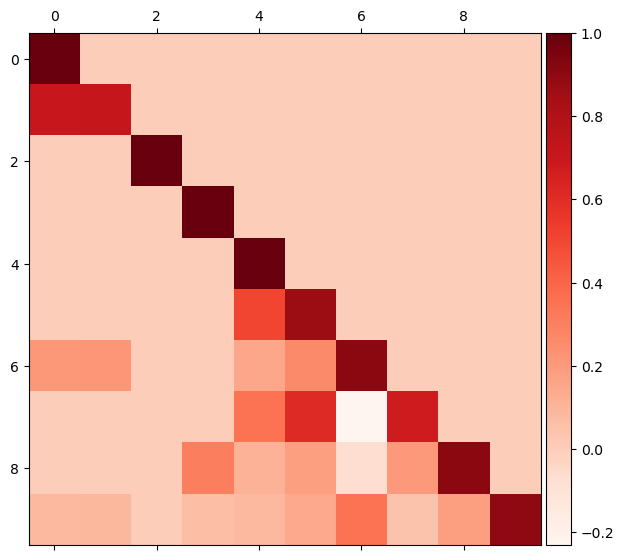

In [6]:
# plt.matshow(np.linalg.cholesky(cor + np.eye(N)))
# plt.colorbar()


fig, ax = plt.subplots(1,1,figsize=(7,7))
r = ax.matshow(np.linalg.cholesky(cor + np.eye(d)), cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

In [7]:
n_sample = 400
Z = np.random.default_rng().multivariate_normal(mean = np.zeros(d), cov = cor + np.eye(d), size = n_sample).T

In [8]:
Y = Z.copy()
# Y = Y**0.1

In [9]:
# Prepare Kernels, transformed data to uniform (from kernel), Scott's optimal bandwiths
kernels_Y = [gaussian_kde(Y[i,:]) for i in range(d)]

U = np.vstack( [np.array([kernels_Y[i].integrate_box_1d(-np.inf, y_i) for y_i in Y[i,:]]) for i in tqdm(range(d)) ])
kernels_U = [gaussian_kde(U[i,:]) for i in range(d)]

h = np.array([(kernels_Y[i].covariance**0.5)[0,0] for i in range(d)])

100%|██████████| 10/10 [00:00<00:00, 73.51it/s]


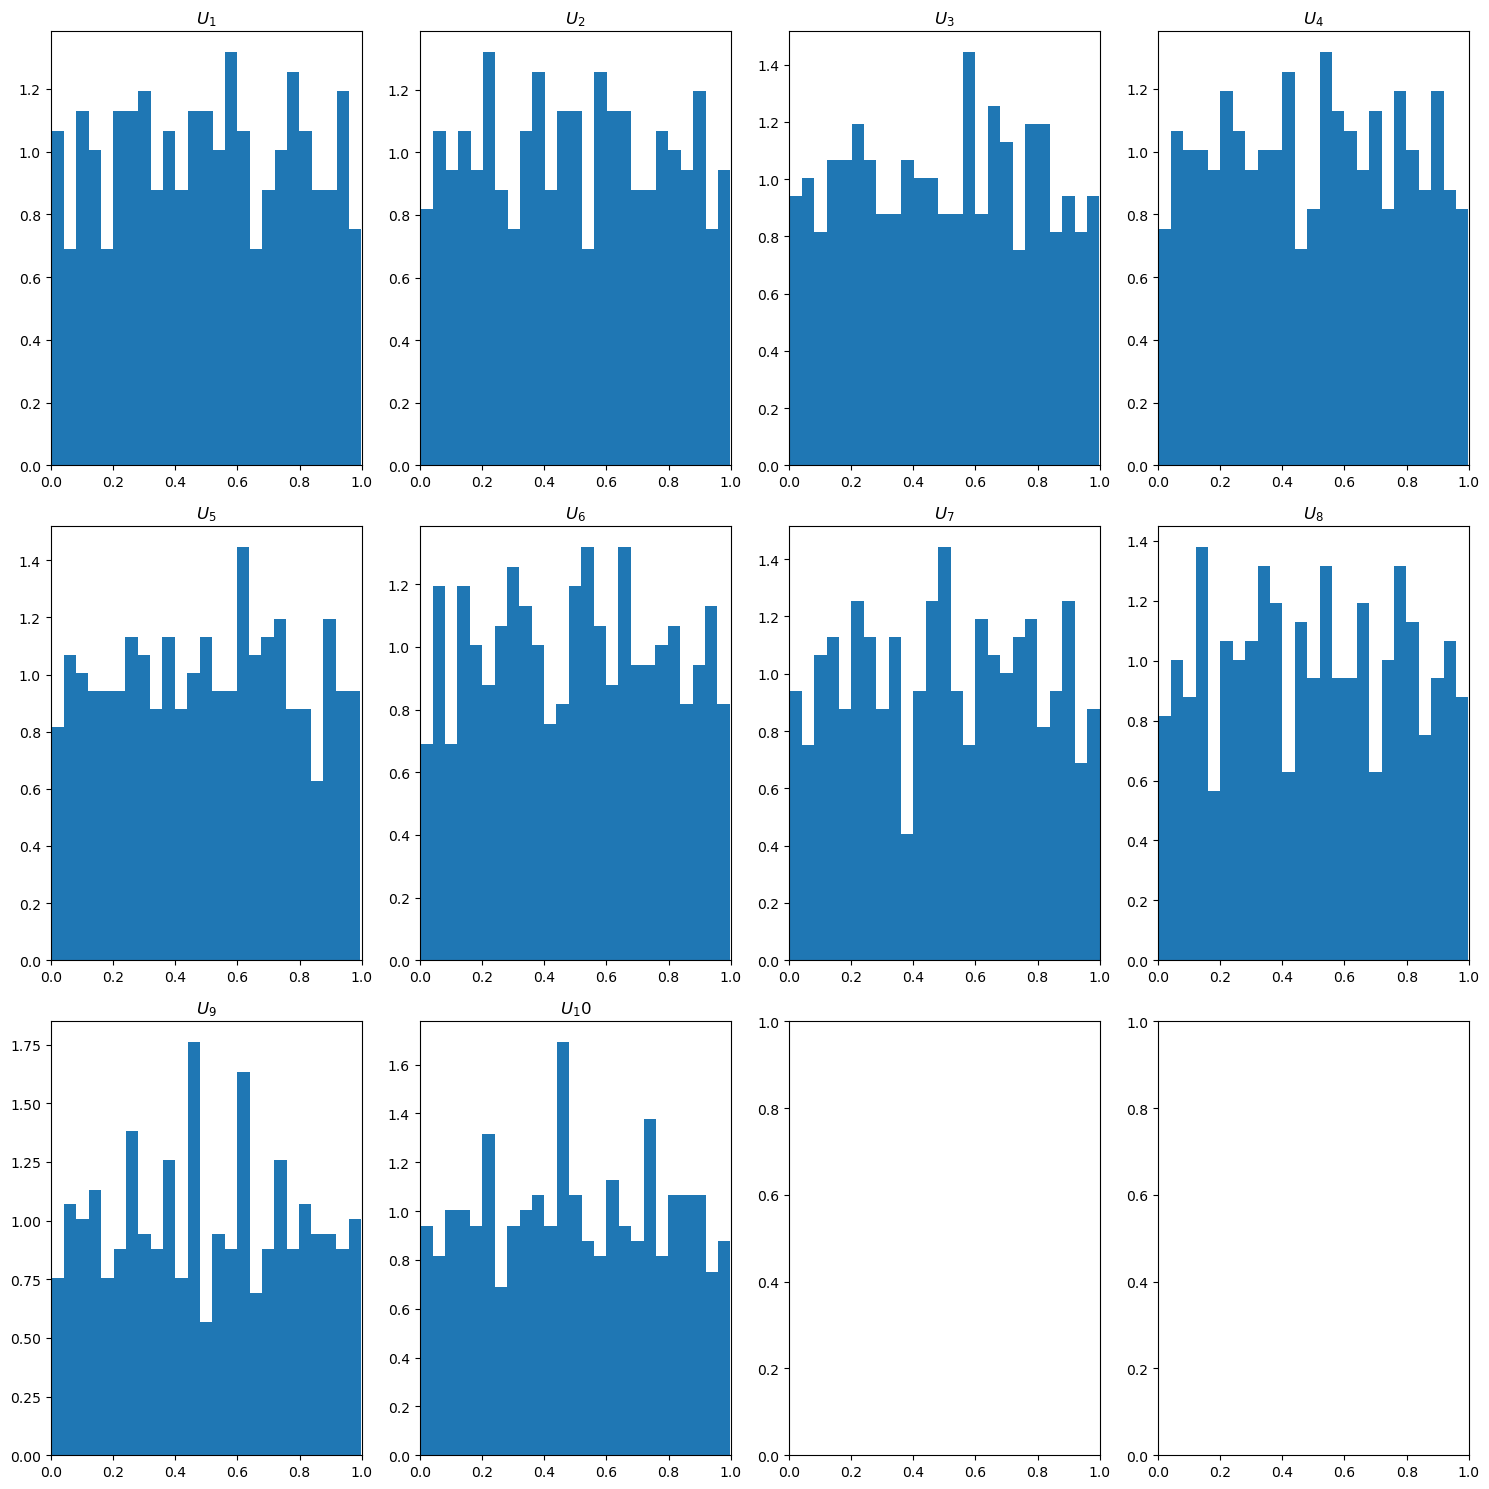

In [12]:
n_cols = int(np.ceil(np.sqrt(d)))
n_rows = int(np.ceil(d / n_cols))
fig, ax = plt.subplots(n_rows,n_cols, figsize=(15,15))
# fig, ax = plt.subplots(1,3, figsize=(8,2.8))

for i in range(d):
    ax.flat[i].hist(U[i,:], density=True, bins = 25)
    ax.flat[i].set_title(f"$U_{i+1}$")
    ax.flat[i].set_xlim([0,1])

fig.tight_layout()
# Gaussian 3x3 small s uniforms
# Gaussian 3x3 medium s uniforms
# Gaussian 3x3 large s uniforms
# Gaussian 3x3 large s power uniforms


# plt.savefig(figures_path + "ND examples/Gaussian 3x3 large s power uniforms.pdf", bbox_inches='tight')

In [17]:
for i in range(d):
    KolmogorovSmirnovTestUnif(U[i])
    print()



Test-stat. :          0.023037803780378008
Adjusted test-stat. : 0.46364731998199765
p-value :             0.9826020740932198

Test-stat. :          0.022506500650065007
Adjusted test-stat. : 0.45295457883288337
p-value :             0.9864616118036218

Test-stat. :          0.022927292729272852
Adjusted test-stat. : 0.46142322982298084
p-value :             0.9834613231213992

Test-stat. :          0.02591909190919084
Adjusted test-stat. : 0.5216346842184203
p-value :             0.948399548142089

Test-stat. :          0.029625712571257012
Adjusted test-stat. : 0.5962322783528331
p-value :             0.869232005873129

Test-stat. :          0.02332258225822581
Adjusted test-stat. : 0.4693786292379236
p-value :             0.9802459148487797

Test-stat. :          0.02302055205520548
Adjusted test-stat. : 0.46330012038703794
p-value :             0.9827382121393787

Test-stat. :          0.021614411441144066
Adjusted test-stat. : 0.43500083745874496
p-value :             0.9915059007

In [19]:
# for evaluating kernel
x_lin = np.linspace(0,1,501) #; x_lin = (x_lin[1:] + x_lin[:-1]) / 2
y_lin = np.linspace(0,1,501) #; y_lin = (y_lin[1:] + y_lin[:-1]) / 2
xx, yy = np.meshgrid(x_lin, y_lin)

xx_eval = xx.flatten()
yy_eval = yy.flatten()

xxyy_eval = np.array([xx.flatten(), yy.flatten()])


Trapz_weights_2d = np.array([[1] + [2 for i in range(xx.shape[1]-2)] + [1]] + 
                             [[2] + [4 for i in range(xx.shape[1]-2)] + [2] for j in range(xx.shape[0] - 2)] + 
                             [[1] + [2 for i in range(xx.shape[1]-2)] + [1]] )

Trapez_weights_1d_x = np.array([1] + [2 for i in range(xx.shape[0] - 2)] + [1])

Trapez_weights_1d_y = np.array([1] + [2 for i in range(xx.shape[1] - 2)] + [1])


In [20]:
G = np.zeros((d,d))

count = 0


for i in range(d-1):
    kernel_i = kernels_U[i]
    # h_i = h[i]
    u_i = U[i,:]
    for j in range(i+1, d):
        print(f"{ count } / { (d*(d-1)/2) :3.0f}    [{100*count/ (d*(d-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")

        u_j = U[j,:]


        kern_centers = np.vstack([u_i,u_j])

        # print( kern_centers.shape[1]**(-1/5) * kern_centers.var()**0.5)

        kern_nn = KernelJones2D_nonnegative_version_Jonas(
            kern_centers,
            proper = False
        )

        
        print("  evaluating..")
        res_nn = kern_nn(xxyy_eval)
        print(f"  prob mass : {res_nn.mean()}")

        
        c_new = res_nn.mean()
        z_nn = res_nn.copy() / c_new
        z_nn = np.reshape(z_nn, xx.shape)

        
        c_xy = (z_nn * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])
        Hxy = - (z_nn * np.log(z_nn) * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])

        
        c_x = (z_nn.mean(axis = 1) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)
        Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)

        
        c_y = (z_nn.mean(axis = 0) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)
        Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)

        # correct for weights
        # Hx = (Hx - np.log(c_x)) / c_x
        # Hy = (Hy - np.log(c_y)) / c_y

        Hx = 0
        Hy = 0
        Hxy = (Hxy - np.log(c_xy)) / c_xy

        G[i,j] = G[j,i] = Hx + Hy - Hxy
        # kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))

        # d_vol = kernel_ij.integrate_box(
        #         low_bounds = [0,0],
        #         high_bounds = [1,1]
        #     )
        
        # # Simple normalization of KDE such that integrates to 1 (no jackknifing)
        # G[i,j] = G[j,i] = \
        #     scipy.integrate.dblquad(
        #         lambda x,y : 
        #             kernel_ij.pdf(np.vstack([x,y])) * \
        #             kernel_ij.logpdf(np.vstack([x,y])),
        #         0,1,
        #         0,1
        #     )[0] / d_vol - np.log(d_vol)

        count += 1
        print(f"{ count } / { (d*(d-1)/2) :3.0f}    [{100*count/ (d*(d-1)/2) :7.2f}%]    ({i}, {j})\033[K")
        

Computing normalization constants...  evaluating..
  prob mass : 1.0070843222385808
1 /  45    [   2.22%]    (0, 1)
Computing normalization constants...  evaluating..
  prob mass : 0.9952465962740876
2 /  45    [   4.44%]    (0, 2)
Computing normalization constants...  evaluating..
  prob mass : 0.9901980393182628
3 /  45    [   6.67%]    (0, 3)
Computing normalization constants...  evaluating..
  prob mass : 0.9964333311100259
4 /  45    [   8.89%]    (0, 4)
Computing normalization constants...  evaluating..
  prob mass : 0.993843410342127
5 /  45    [  11.11%]    (0, 5)
Computing normalization constants...  evaluating..
  prob mass : 0.9883368722440017
6 /  45    [  13.33%]    (0, 6)
Computing normalization constants...  evaluating..
  prob mass : 0.9913510602170549
7 /  45    [  15.56%]    (0, 7)
Computing normalization constants...  evaluating..
  prob mass : 0.9921171681518951
8 /  45    [  17.78%]    (0, 8)
Computing normalization constants...  evaluating..
  prob mass : 0.990054

In [21]:
G

array([[0.        , 0.28790458, 0.02197188, 0.01840078, 0.02866139,
        0.02320862, 0.02817747, 0.02379218, 0.01866733, 0.01949191],
       [0.28790458, 0.        , 0.01796975, 0.0204246 , 0.0241772 ,
        0.02291335, 0.05592183, 0.0233016 , 0.02268047, 0.04357294],
       [0.02197188, 0.01796975, 0.        , 0.01723872, 0.01491987,
        0.01305805, 0.01984996, 0.02144568, 0.01317178, 0.0185654 ],
       [0.01840078, 0.0204246 , 0.01723872, 0.        , 0.0282416 ,
        0.01779989, 0.02145355, 0.016695  , 0.06725127, 0.01951413],
       [0.02866139, 0.0241772 , 0.01491987, 0.0282416 , 0.        ,
        0.14620954, 0.03718588, 0.09495993, 0.02943187, 0.022366  ],
       [0.02320862, 0.02291335, 0.01305805, 0.01779989, 0.14620954,
        0.        , 0.0651924 , 0.32646749, 0.04180091, 0.0348653 ],
       [0.02817747, 0.05592183, 0.01984996, 0.02145355, 0.03718588,
        0.0651924 , 0.        , 0.02391482, 0.02954695, 0.08138413],
       [0.02379218, 0.0233016 , 0.0214456

# Using symmetrical G_obs

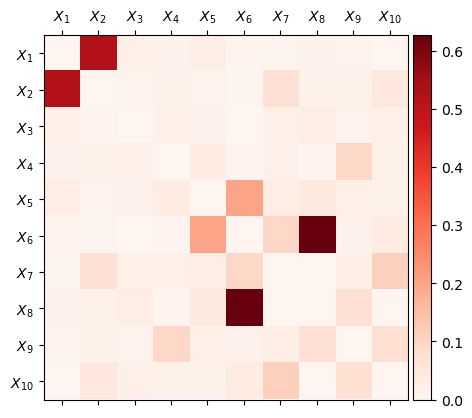

In [34]:
G_dir = ND(G.copy(), alpha=0, beta=0.99)

fig, ax = plt.subplots(1,1,figsize=(5,5))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

labels_select = Y[:,0]

plt.colorbar(r, cax=cax)
try:
    # ax.set_xticks([x+2 for x in range(labels_select.__len__())], labels_select, rotation='vertical');
    ax.set_xticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
    ax.set_yticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
except:
    None

# plt.savefig(figures_path + "ND examples/Gaussian network 10 - G_dir - symmetric.pdf", bbox_inches='tight')

In [35]:
G_dir

array([[-0.22747249,  0.52248949,  0.02427337,  0.01413261,  0.02763469,
         0.00972947,  0.00363939,  0.01451962,  0.0115496 , -0.00261011],
       [ 0.52248949, -0.23564111,  0.01084016,  0.01662185,  0.01207755,
         0.00280674,  0.07145929,  0.01509636,  0.01564801,  0.05323241],
       [ 0.02427337,  0.01084016, -0.00421911,  0.02113949,  0.01426853,
        -0.0024933 ,  0.02253867,  0.0271321 ,  0.01092355,  0.02095508],
       [ 0.01413261,  0.01662185,  0.02113949, -0.0138093 ,  0.03280563,
         0.00651449,  0.02106947,  0.00610446,  0.09551467,  0.0151377 ],
       [ 0.02763469,  0.01207755,  0.01426853,  0.03280563, -0.05649078,
         0.19980603,  0.03101635,  0.04606875,  0.0224545 ,  0.01490283],
       [ 0.00972947,  0.00280674, -0.0024933 ,  0.00651449,  0.19980603,
        -0.36005045,  0.09322365,  0.62660471,  0.0131947 ,  0.03313421],
       [ 0.00363939,  0.07145929,  0.02253867,  0.02106947,  0.03101635,
         0.09322365, -0.03205545, -0.02220783

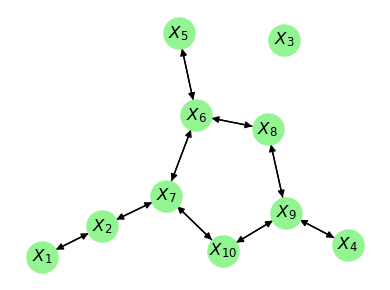

In [42]:
# graph plot
fig, ax = plt.subplots(1,1,figsize=(4,3))
gr = nx.from_numpy_array(G_dir > 0.06, create_using = nx.DiGraph)
pos = graphviz_layout(gr)
nx.draw(gr, pos = pos, node_size = 500, with_labels= True, ax = ax, node_color='#93F592', labels = { k:v for (k,v) in zip(range(d), var_names)} )
fig.tight_layout()
# plt.savefig(figures_path + "ND examples/Gaussian network 10 - G_dir as graph - symmetric.pdf", bbox_inches='tight')

# Using triangular (upper) G_obs

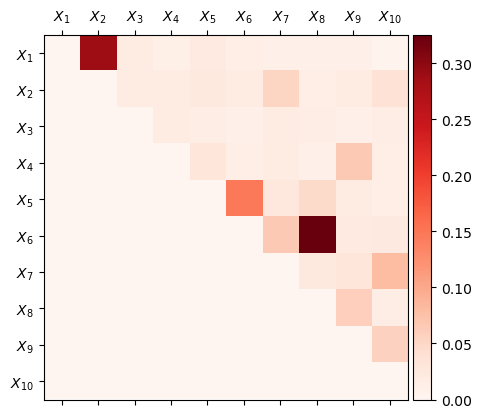

In [58]:
# G_dir = ND(np.triu(G.copy()), alpha=0, beta=0.99)
temp = np.triu(G.copy())
G_dir = temp @ np.linalg.pinv(np.eye(d) + temp)

fig, ax = plt.subplots(1,1,figsize=(5,5))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

labels_select = Y[:,0]

plt.colorbar(r, cax=cax)
try:
    # ax.set_xticks([x+2 for x in range(labels_select.__len__())], labels_select, rotation='vertical');
    ax.set_xticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
    ax.set_yticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
except:
    None

# plt.savefig(figures_path + "ND examples/Gaussian network 10 - G_dir - triangular.pdf", bbox_inches='tight')

In [48]:
G_dir

array([[ 2.08975273e-16,  2.87904577e-01,  1.67983043e-02,
         1.22308654e-02,  2.11046162e-02,  1.30890050e-02,
         9.84337770e-03,  1.00064650e-02,  9.04665795e-03,
         3.96205222e-03],
       [-1.17232136e-17, -4.08166370e-17,  1.79697478e-02,
         2.01148292e-02,  2.33410202e-02,  1.89079747e-02,
         5.30329844e-02,  1.29228311e-02,  1.72874353e-02,
         3.61205788e-02],
       [-9.54474685e-18, -2.21750848e-17, -9.19496726e-18,
         1.72387230e-02,  1.44330258e-02,  1.06409557e-02,
         1.82497097e-02,  1.58769585e-02,  9.67077385e-03,
         1.51974949e-02],
       [-1.01619811e-17, -2.85390330e-17, -1.19503429e-17,
         1.90489123e-18,  2.82416037e-02,  1.36706960e-02,
         1.95121332e-02,  9.08351559e-03,  6.47383909e-02,
         1.29658691e-02],
       [-5.24173446e-17, -9.19627892e-17, -5.23790721e-18,
        -3.83191966e-17,  2.24243772e-17,  1.46209540e-01,
         2.76541287e-02,  4.65659249e-02,  1.97670709e-02,
         1.

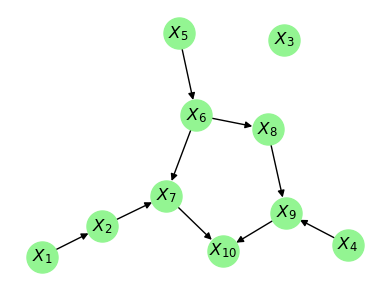

In [57]:
# graph plot
fig, ax = plt.subplots(1,1,figsize=(4,3))
gr = nx.from_numpy_array(G_dir > 0.05, create_using = nx.DiGraph)
pos = graphviz_layout(gr)
nx.draw(gr, pos = pos, node_size = 500, with_labels= True, ax = ax, node_color='#93F592', labels = { k:v for (k,v) in zip(range(d), var_names)} )
fig.tight_layout()
# plt.savefig(figures_path + "ND examples/Gaussian network 10 - G_dir as graph - triangular.pdf", bbox_inches='tight')

# Theoretical G_obs

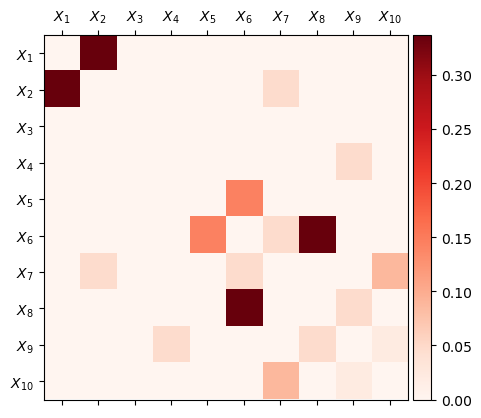

In [61]:


fig, ax = plt.subplots(1,1,figsize=(5,5))
r = ax.matshow(-0.5 * np.log(1 - (Rho + Rho.T)**2), cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

labels_select = Y[:,0]

plt.colorbar(r, cax=cax)
try:
    # ax.set_xticks([x+2 for x in range(labels_select.__len__())], labels_select, rotation='vertical');
    ax.set_xticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
    ax.set_yticks(
        [x for x in range(labels_select.__len__())], 
        ['$X_{' + str(x+1) + '}$' for x in range(labels_select.__len__())]
    );
except:
    None

# plt.savefig(figures_path + "ND examples/Gaussian network 10 - G_dir true - symmetric.pdf", bbox_inches='tight')

In [109]:
# n_mesh = 100
# X1v, X2v = np.meshgrid(
#     np.linspace(0,1,n_mesh), 
#     np.linspace(0,1,n_mesh))

# kernel_ij = gaussian_kde(np.vstack([U[0,:],U[1,:]]))

# Zv = np.reshape(kernel_ij.evaluate(np.vstack([X1v.ravel(), X2v.ravel()])), (n_mesh,n_mesh))

Text(0, 0.5, '$u_2$')

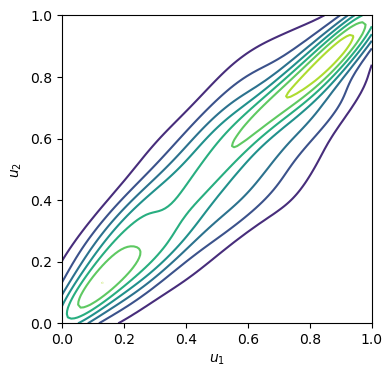

In [110]:
# fig, ax = plt.subplots(1,1, figsize=(4,4))
# ax.contour(X1v, X2v, Zv );
# ax.set_xlabel("$u_1$")
# ax.set_ylabel("$u_2$")

# # plt.savefig(figures_path + "ND examples/Gaussian copula sample contour.pdf", bbox_inches='tight')

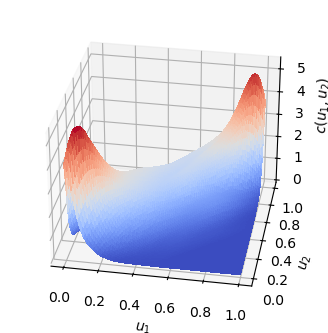

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (4,4))
# ax.plot_trisurf(X1v.ravel(), X2v.ravel(), Zv.ravel(), cmap=cm.coolwarm ,linewidth=0.2, antialiased=False)
# ax.view_init(30, -80, 0)
# ax.set_xlabel("$u_1$")
# ax.set_ylabel("$u_2$")
# ax.set_zlabel("$c(u_1,u_2)$")
# plt.savefig(figures_path + "ND examples/Gaussian copula sample pdf.pdf", bbox_inches='tight')

In [ ]:
# # theoretical copula density for Gaussian
# rho = 0.9
# R = np.array([[1,rho],[rho,1]])
# Ri = np.linalg.pinv(R) - np.identity(2)
# n_mesh = 50

# U1v, U2v = np.meshgrid(np.linspace(0.01,0.99,n_mesh), np.linspace(0.01 , 0.99,n_mesh))

# U1v = U1v.ravel()
# U2v = U2v.ravel()

# X1v = scipy.stats.norm.ppf(U1v)
# X2v = scipy.stats.norm.ppf(U2v)

# Xv = np.vstack( (X1v, X2v ))


# Zv = (Xv * (Ri @ Xv)).sum(axis=0)
# Zv = 1 / np.sqrt(np.linalg.det(R)) * np.exp(-Zv / 2)

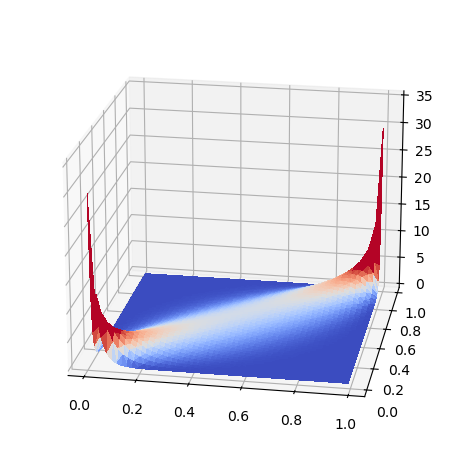

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_trisurf(U1v, U2v, Zv, cmap=cm.coolwarm ,linewidth=0.2, antialiased=False, vmax = 5)
# ax.set_zlim(0 , 35)
# ax.view_init(20, -80, 0)
# fig.tight_layout()
# # plt.savefig(figures_path + "ND examples/Gaussian copula theoretical pdf.pdf", bbox_inches='tight')

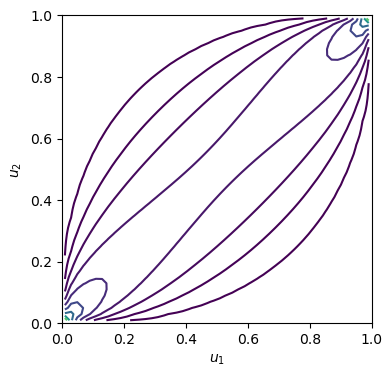

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,4))
# res = ax.contour(
#     np.reshape(U1v, (n_mesh,n_mesh)), 
#     np.reshape(U2v, (n_mesh,n_mesh)),
#     np.reshape(Zv, (n_mesh,n_mesh)),
#     levels=  32 * np.linspace(0.1,1,10)**3
#     );
# ax.set_xlabel("$u_1$")
# ax.set_ylabel("$u_2$")
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

# # np.exp(np.linspace(-7,3.5,10))
# # np.sort([   4.,  8., 12., 16., 20., 24., 28., 32.] + [1,2] + [0.1] + [0.001] + [2.4])

# # plt.savefig(figures_path + "ND examples/Gaussian copula theoretical contour.pdf", bbox_inches='tight')

# Test for correlation

In [253]:
mi = 0
np.sqrt(1 - np.exp(-2 * mi))

0.0

## Final CI abs

CI [a,b]. Correlation different from 0. Using reflected density.
CI abs rho: [0.010709, 0.131363]


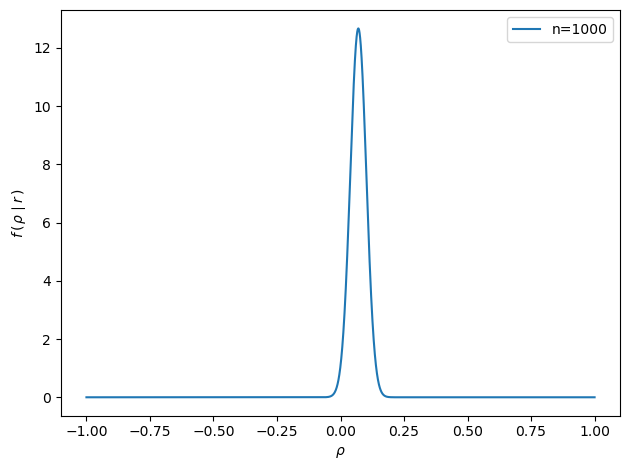

In [479]:
n = 1000
v = n-1

alpha = 0.05
r = 0.07    # sample (abs) correlation



# ensure r is non-negative
r = np.abs(r)

nomalization_const = v * (v-1) / np.sqrt(2*np.pi) * np.exp( scipy.special.loggamma(v-1) - scipy.special.loggamma(v + 0.5) )

# Check if with out abs, correlation CI contains 0
rho_bounds = np.linspace(-1,1,1_000_001)
rho = (rho_bounds[1:] + rho_bounds[:-1])/2
pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()
CI_rho = [rho_bounds[1:][np.cumsum(pdf_rho) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_rho) * dh > (1-alpha/2)][0]]


plt.plot(rho,pdf_rho, label=f"n={n}")


# prepare for next step
rho_bounds = np.linspace(0,1,1_000_001)
rho = (rho_bounds[1:] + rho_bounds[:-1])/2
pdf_abs = nomalization_const * ( np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2) + np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1+rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1-rho*r)/2) )
dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()

# If contains 0, use refelct-added density to calculate instead
if ( (CI_rho[0] <= 0 ) & (0 <= CI_rho[1]) ):
    print("CI [0,b]. Correlation not different from 0. Using reflected density.")
    CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha)][0]]

else:
    print("CI [a,b]. Correlation different from 0. Using reflected density.")
    CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha/2)][0]]

# # plt_idx = (rho >-0.1) & (rho < 0.1)
# # plt.plot(rho[plt_idx],pdf_rho[plt_idx])
# plt.plot(rho,pdf_abs)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

plt.xlabel(r"$\rho$")
plt.ylabel(r"$f\,\left(\,\rho \mid r\,\right)$");




# print(f"probability mass: {pdf_abs.sum() * (rho_bounds[-1] - rho_bounds[0]) / pdf_abs.__len__()}")

# # Computing CI for absolute correlation
# CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * 2 / rho.__len__() < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]

# if not ( (r >= CI_rho[0]) & (r <= CI_rho[1]) ):
#     print("CI does not contain sample, switching to other def.")
#     # rho_bounds = np.linspace(-1,1,1_000_001)
#     # rho = (rho_bounds[1:] + rho_bounds[:-1])/2
#     # pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
#     CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha)][0]]
#     # CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_rho) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]
# # if CI_rho[0] < 0:
# #     CI_rho[0] = 0
print(f"CI abs rho: {CI_rho}")
# note that for the lower bound, we take from 1 and not 0. This is because cumsum does not return 0 as the forst element, which it should do if we wanted use from index 0

# # get the usual 1.9599 when r = 0 as we would expect from the student-t distribution


# # 0, 0.016449999999999854

# rho_bounds = np.linspace(-1,1,1_000_001)
# rho = (rho_bounds[1:] + rho_bounds[:-1])/2
# pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
# plt.plot(rho,pdf_rho)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

# plt.xlim(-0.03, 0.03)

plt.legend()
plt.tight_layout()

## Plot of confidence distribution

CI [a,b]. Correlation different from 0. Using reflected density.
CI [a,b]. Correlation different from 0. Using reflected density.
CI [a,b]. Correlation different from 0. Using reflected density.


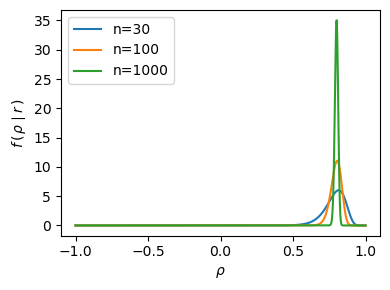

In [473]:
plt.figure(figsize=(4,3))

alpha = 0.05
r = 0.8    # sample (abs) correlation

for n in [30, 100, 1000]:

    v = n-1





    # ensure r is non-negative
    r = np.abs(r)

    nomalization_const = v * (v-1) / np.sqrt(2*np.pi) * np.exp( scipy.special.loggamma(v-1) - scipy.special.loggamma(v + 0.5) )

    # Check if with out abs, correlation CI contains 0
    rho_bounds = np.linspace(-1,1,1_000_001)
    rho = (rho_bounds[1:] + rho_bounds[:-1])/2
    pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
    dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()
    CI_rho = [rho_bounds[1:][np.cumsum(pdf_rho) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_rho) * dh > (1-alpha/2)][0]]


    plt.plot(rho,pdf_rho, label=f"n={n}")


    # prepare for next step
    rho_bounds = np.linspace(0,1,1_000_001)
    rho = (rho_bounds[1:] + rho_bounds[:-1])/2
    pdf_abs = nomalization_const * ( np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2) + np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1+rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1-rho*r)/2) )
    dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()

    # If contains 0, use refelct-added density to calculate instead
    if ( (CI_rho[0] <= 0 ) & (0 <= CI_rho[1]) ):
        print("CI [0,b]. Correlation not different from 0. Using reflected density.")
        CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha)][0]]

    else:
        print("CI [a,b]. Correlation different from 0. Using reflected density.")
        CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha/2)][0]]

    # # plt_idx = (rho >-0.1) & (rho < 0.1)
    # # plt.plot(rho[plt_idx],pdf_rho[plt_idx])
    # plt.plot(rho,pdf_abs)
    # plt.xlabel(r"$\left|\rho\right|$")
    # plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

plt.xlabel(r"$\rho$")
plt.ylabel(r"$f\,\left(\,\rho \mid r\,\right)$");




# print(f"probability mass: {pdf_abs.sum() * (rho_bounds[-1] - rho_bounds[0]) / pdf_abs.__len__()}")

# # Computing CI for absolute correlation
# CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * 2 / rho.__len__() < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]

# if not ( (r >= CI_rho[0]) & (r <= CI_rho[1]) ):
#     print("CI does not contain sample, switching to other def.")
#     # rho_bounds = np.linspace(-1,1,1_000_001)
#     # rho = (rho_bounds[1:] + rho_bounds[:-1])/2
#     # pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
#     CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha)][0]]
#     # CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_rho) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]
# # if CI_rho[0] < 0:
# #     CI_rho[0] = 0
# print(f"CI abs rho: {CI_rho}")
# note that for the lower bound, we take from 1 and not 0. This is because cumsum does not return 0 as the forst element, which it should do if we wanted use from index 0

# # get the usual 1.9599 when r = 0 as we would expect from the student-t distribution


# # 0, 0.016449999999999854

# rho_bounds = np.linspace(-1,1,1_000_001)
# rho = (rho_bounds[1:] + rho_bounds[:-1])/2
# pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
# plt.plot(rho,pdf_rho)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

# plt.xlim(-0.03, 0.03)

plt.legend()
plt.tight_layout()



# plt.savefig(figures_path + "Gaussian correlation confidence dist/density comparison r 0.8.pdf", bbox_inches='tight')

In [20]:
temp = -0.5 * np.log(1 - cor**2)
np.fill_diagonal(temp, 0)
# temp = temp @ np.linalg.pinv(np.eye(3) - temp)
temp

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1580882354.py:1: RuntimeWarning: divide by zero encountered in log
  temp = -0.5 * np.log(1 - cor**2)


array([[ 0.       ,  0.8303656, -0.       ],
       [ 0.8303656,  0.       , -0.       ],
       [-0.       , -0.       ,  0.       ]])

In [31]:
A = np.ones((3,3)) * 7
# A[0,1] = A[1,0] = 0
np.linalg.eig(A)

EigResult(eigenvalues=array([2.10000000e+01, 0.00000000e+00, 1.62635101e-15]), eigenvectors=array([[ 5.77350269e-01,  1.02237325e-16,  6.90643277e-01],
       [ 5.77350269e-01, -7.07106781e-01, -7.22493878e-01],
       [ 5.77350269e-01,  7.07106781e-01,  3.18506015e-02]]))

In [22]:
np.linalg.eig(temp * 0.5/0.84)

EigResult(eigenvalues=array([ 0.49426524, -0.49426524,  0.        ]), eigenvectors=array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]))

In [16]:
temp = cor.copy()
np.fill_diagonal(temp,0)
temp = np.triu(temp)
temp @ np.linalg.pinv(np.eye(3) - temp)

array([[-4.99600361e-17,  9.00000000e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

# error mutual information

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: invalid value encountered in multiply
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: invalid value encountered in subtract
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)


plotting surface


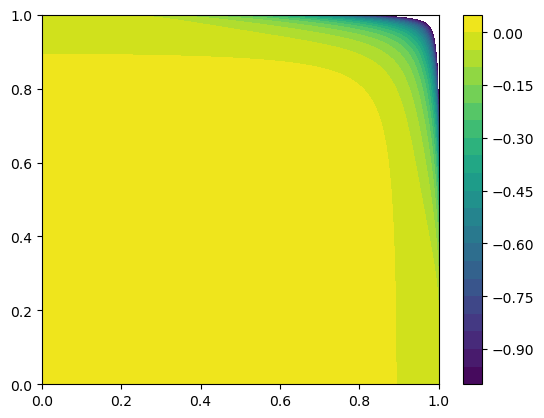

In [81]:
def MIError(x,y):
    return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)

xx, yy = np.meshgrid(np.linspace(0,1,3_000), np.linspace(0,1,3_000))

# fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
zz = MIError(xx,yy)
zz[np.abs(zz) > 1] = np.nan

print("plotting surface")
# ax.plot_surface(xx,yy,zz,cmap=cm.coolwarm, antialiased=False)


# plt.show()

# plt.imshow(zz,origin='lower',interpolation='bilinear')
# plt.show()


plt.contourf(xx,yy,zz, 20)
plt.colorbar(extend = "neither")

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\3596734464.py:2: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\3596734464.py:2: RuntimeWarning: invalid value encountered in multiply
  return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)


plotting surface


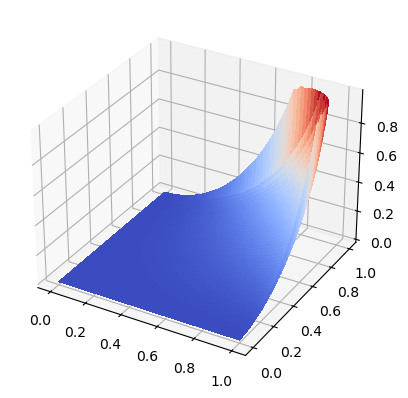

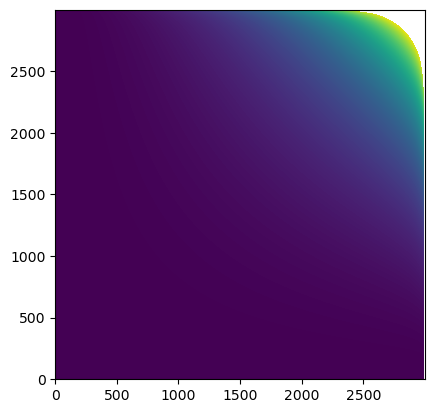

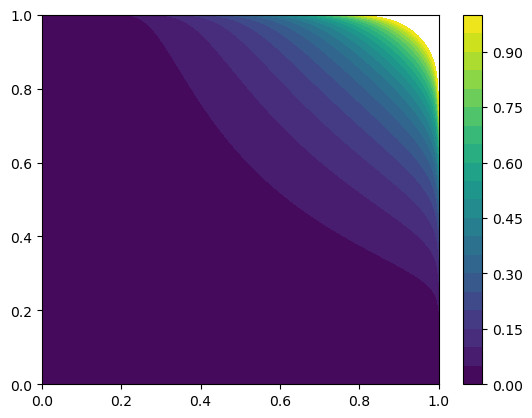

In [78]:
def MIError(x,y, rho3 = 0.8):
    return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)

xx, yy = np.meshgrid(np.linspace(0,1,3_000), np.linspace(0,1,3_000))

fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
zz = MIError(xx,yy)
zz[np.abs(zz) > 1] = np.nan

print("plotting surface")
ax.plot_surface(xx,yy,zz,cmap=cm.coolwarm, antialiased=False)
# ax.view_init(90, 0)
plt.show()

plt.imshow(zz,origin='lower',interpolation='bilinear')
plt.show()

plt.contourf(xx,yy,zz, 20, vmax = 1)
plt.colorbar(extend = "neither")

In [2]:
import numpy as np

In [79]:
# L = np.array([[1,0,0],[0.5,1,0],[0,0,1]])
L = np.array([[1,0,0],[0.5,(1 - 0.5**2)**0.5,0],[0,0.5,(1 - 0.5**2)**0.5]])
P = np.zeros((3,3))
P[0,1] = 1
P[1,2] = 1
P[2,0] = 1


L

array([[1.       , 0.       , 0.       ],
       [0.5      , 0.8660254, 0.       ],
       [0.       , 0.5      , 0.8660254]])

In [80]:
L @ L.T

array([[1.       , 0.5      , 0.       ],
       [0.5      , 1.       , 0.4330127],
       [0.       , 0.4330127, 1.       ]])

In [81]:
P @ L @ L.T @ P.T

array([[1.       , 0.4330127, 0.5      ],
       [0.4330127, 1.       , 0.       ],
       [0.5      , 0.       , 1.       ]])

In [92]:
G_obs = -0.5 * np.log( 1 - (L @ L.T)**2)
np.fill_diagonal(G_obs, 0)
print(G_obs)
ND(G_obs)

[[ 0.          0.14384104 -0.        ]
 [ 0.14384104  0.          0.10381968]
 [-0.          0.10381968  0.        ]]


C:\Users\jonas\AppData\Local\Temp\ipykernel_31804\4294099351.py:1: RuntimeWarning: divide by zero encountered in log
  G_obs = -0.5 * np.log( 1 - (L @ L.T)**2)


array([[-0.21624196,  0.53606188, -0.15607626],
       [ 0.53606188, -0.32889262,  0.38691166],
       [-0.15607626,  0.38691166, -0.11265066]])

In [91]:
G_obs = -0.5 * np.log( 1 - (P @ L @ L.T @ P.T)**2)
np.fill_diagonal(G_obs, 0)
print(G_obs)
ND(G_obs)

[[ 0.          0.10381968  0.14384104]
 [ 0.10381968  0.         -0.        ]
 [ 0.14384104 -0.          0.        ]]


C:\Users\jonas\AppData\Local\Temp\ipykernel_31804\3461153774.py:1: RuntimeWarning: divide by zero encountered in log
  G_obs = -0.5 * np.log( 1 - (P @ L @ L.T @ P.T)**2)


array([[-0.32889262,  0.38691166,  0.53606188],
       [ 0.38691166, -0.11265066, -0.15607626],
       [ 0.53606188, -0.15607626, -0.21624196]])

In [71]:
np.linalg.cholesky(P @ L @ L.T @ P.T)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.4330127 ,  0.90138782,  0.        ],
       [ 0.5       , -0.24019223,  0.83205029]])

In [53]:
P = np.eye(10)

i = 2
j = 5
P[i,j] = 1
P[j,i] = 1
P[i,i] = 0
P[j,j] = 0


np.linalg.det(P)

-1.0